In [1]:
import fiftyone as fo
import fiftyone.utils.coco as fouc
from fiftyone.core.labels import Detection

import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.utils
import torch.utils.data

import torchvision
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

import matplotlib.pyplot as plt

import cv2

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

import os
import importlib

import findpeaks

/tmp/ipykernel_17312/1324473247.py:21: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter
/tmp/ipykernel_17312/1324473247.py:22: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance


Implementing land masking with process from this paper [Ship detection in SAR images using efficient land masking methods](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/9093/1/Ship-detection-in-SAR-images-using-efficient-land-masking-methods/10.1117/12.2053171.short?SSO=1)


In [2]:
# Loading Dataset
name = "HRSID"
if name in fo.list_datasets():
    dataset_traintest = fo.load_dataset(name)
else:
    dataset_dir = os.path.abspath("Datasets/HRSID")
    # The type of the dataset being imported
    dataset_type = fo.types.COCODetectionDataset

    dataset_traintest = fo.Dataset.from_dir(
        dataset_dir=dataset_dir,
        dataset_type=dataset_type,
        name=name,
    )

In [29]:
name = "HRSID_offshore"
if name in fo.list_datasets():
    dataset_offshore = fo.load_dataset(name)
else:
    dataset_dir = os.path.abspath("Datasets/HRSID")
    label_path = os.path.abspath("Datasets/HRSID/annotations/offshore.json")
    # The type of the dataset being imported
    dataset_type = fo.types.COCODetectionDataset

    dataset_offshore = fo.Dataset.from_dir(
        dataset_dir=dataset_dir,
        dataset_type=dataset_type,
        labels_path=label_path,
        name=name,
    )

In [30]:
for sample in dataset_offshore:
    for det in sample["segmentations"].detections:
        det.label = "offshore_ship"
    for det in sample["detections"].detections:
        det.label = "offshore_ship"
    sample.save()


In [32]:
name = "HRSID_inshore"
if name in fo.list_datasets():
    dataset_inshore = fo.load_dataset(name)
else:
    dataset_dir = os.path.abspath("Datasets/HRSID")
    label_path = os.path.abspath("Datasets/HRSID/annotations/inshore.json")
    # The type of the dataset being imported
    dataset_type = fo.types.COCODetectionDataset

    dataset_traintest = fo.Dataset.from_dir(
        dataset_dir=dataset_dir,
        dataset_type=dataset_type,
        labels_path=label_path,
        name=name,
    )

In [33]:
for sample in dataset_inshore:
    for det in sample["segmentations"].detections:
        det.label = "inshore_ship"
    for det in sample["detections"].detections:
        det.label = "inshore_ship"
    sample.save()


In [34]:
HRSID_combined = fo.Dataset()
HRSID_combined.merge_samples(dataset_offshore)

In [35]:
HRSID_combined.merge_samples(dataset_inshore)

In [36]:
HRSID_combined

Name:        2023.05.16.22.24.00
Media type:  image
Num samples: 5604
Persistent:  False
Tags:        []
Sample fields:
    id:            fiftyone.core.fields.ObjectIdField
    filepath:      fiftyone.core.fields.StringField
    tags:          fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [39]:
HRSID_combined.export(
    dataset_type=fo.types.COCODetectionDataset,
    labels_path=os.path.abspath("Datasets/HRSID/annotations/inshore_offshore.json"),
    label_field="segmentations"
)

 100% |███████████████| 5604/5604 [2.7m elapsed, 0s remaining, 27.2 samples/s]      


In [40]:
name = "HRSID_both"
if name in fo.list_datasets():
    dataset_both = fo.load_dataset(name)
else:
    dataset_dir = os.path.abspath("Datasets/HRSID")
    label_path = os.path.abspath("Datasets/HRSID/annotations/inshore_offshore.json")
    # The type of the dataset being imported
    dataset_type = fo.types.COCODetectionDataset

    dataset_both = fo.Dataset.from_dir(
        dataset_dir=dataset_dir,
        dataset_type=dataset_type,
        labels_path=label_path,
        name=name,
    )

 100% |███████████████| 5604/5604 [35.5s elapsed, 0s remaining, 121.6 samples/s]      


In [42]:
fo.list_datasets()

['2023.05.16.22.24.00',
 'HRSID_both',
 'HRSID_inshore',
 'HRSID_offshore',
 'HRSID_test',
 'HRSID_train']

In [41]:
session = fo.launch_app()

In [78]:
x = torch.rand(10, 10, 1)
print("original", x)

x_mean = uniform_filter(x, (3, 3, 1))
print("original", x)
print("xmean", type(x_mean))

x_sq = uniform_filter(x**2, (3, 3, 1))
print("original", x)
print("xsq", x_sq)

x_var = x_sq - x_mean**2

x_o_var = variance(np.asarray(x))

x_weight = x_var / (x_var + x_o_var)
x = x_mean + x_weight * (np.asarray(x) - x_mean)
print("original", type(x))

original tensor([[[0.7260],
         [0.0703],
         [0.7493],
         [0.9646],
         [0.5074],
         [0.3825],
         [0.7265],
         [0.0959],
         [0.5820],
         [0.6143]],

        [[0.7970],
         [0.9771],
         [0.1953],
         [0.6931],
         [0.6311],
         [0.3539],
         [0.9114],
         [0.0585],
         [0.0253],
         [0.8621]],

        [[0.8657],
         [0.0833],
         [0.8750],
         [0.5169],
         [0.9278],
         [0.8457],
         [0.6946],
         [0.5470],
         [0.5587],
         [0.9855]],

        [[0.2479],
         [0.2724],
         [0.2391],
         [0.3378],
         [0.1231],
         [0.7060],
         [0.7575],
         [0.0761],
         [0.9386],
         [0.9832]],

        [[0.0429],
         [0.3672],
         [0.2183],
         [0.8821],
         [0.7856],
         [0.3735],
         [0.0812],
         [0.2983],
         [0.2601],
         [0.3581]],

        [[0.6918],
         [0.

In [4]:
img_paths = dataset_traintest.values("filepath")

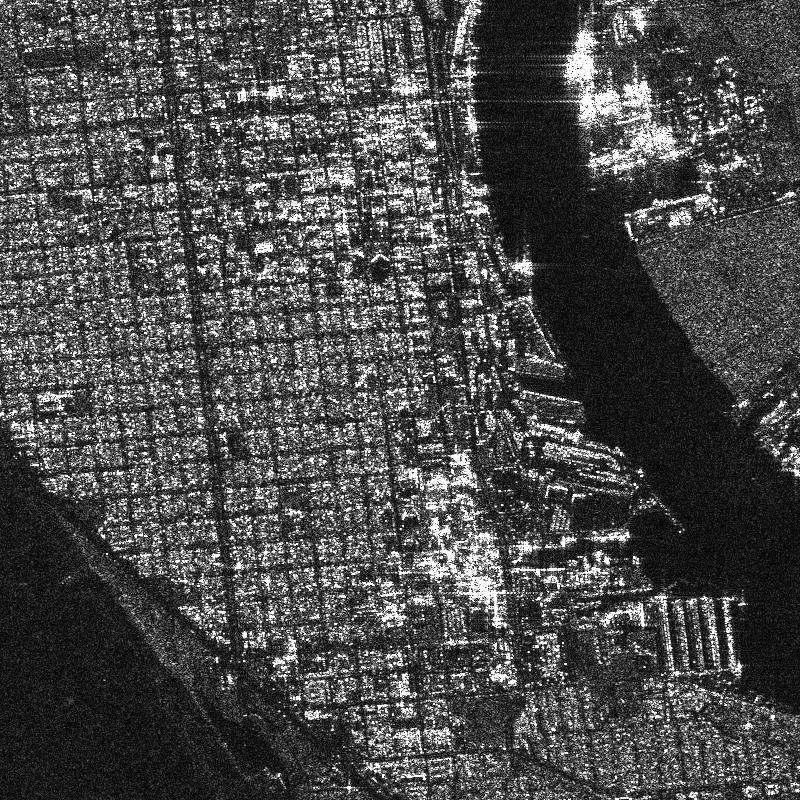

In [24]:
img1 = Image.open(img_paths[1]).convert("RGB")
img1.show()

In [19]:
def lee_filter3(img, size):
    img_mean = uniform_filter(img, (size, size, 3))
    img_sqr_mean = uniform_filter(img**2, (size, size, 3))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

def lee_filter1(img, size):
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [52]:
img1_lee = findpeaks.lee_enhanced_filter((np.array(img1)/255)[:,:,0], 11, cu=.01)*255
(np.array(img1)/255)[:,:,0].shape

(800, 800)

(800, 800, 3)


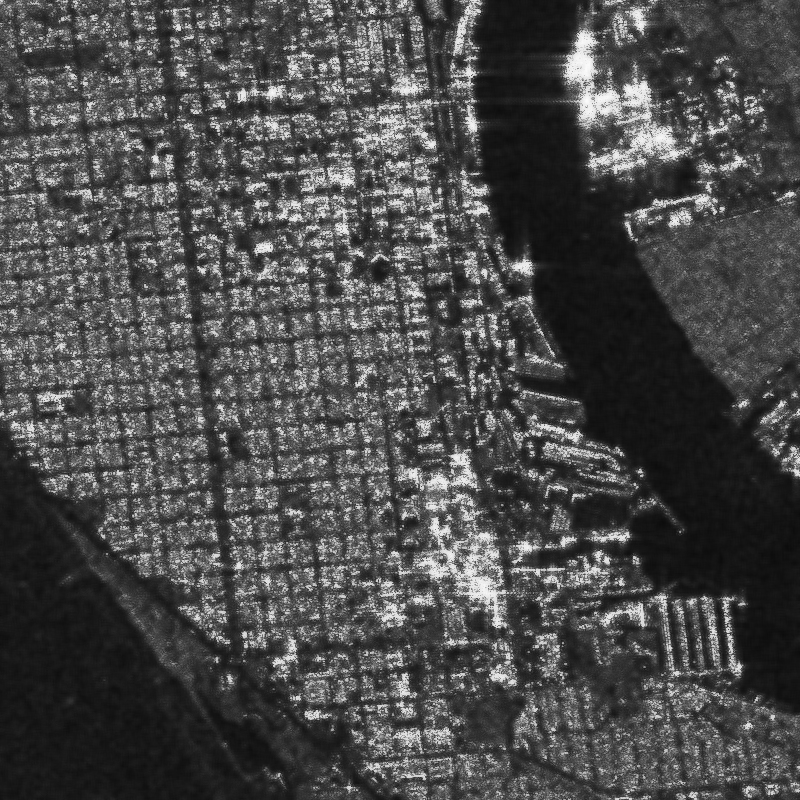

In [26]:
img1_lee = lee_filter3(np.array(img1)/255, 7) * 255
img1_lee = img1_lee.astype(np.uint8)
print(img1_lee.shape)
# img1_lee = Image.fromarray(np.repeat(img1_lee[:, :, np.newaxis], 3, axis=2), 'RGB')
img1_lee = Image.fromarray(img1_lee, 'RGB')
img1_lee.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


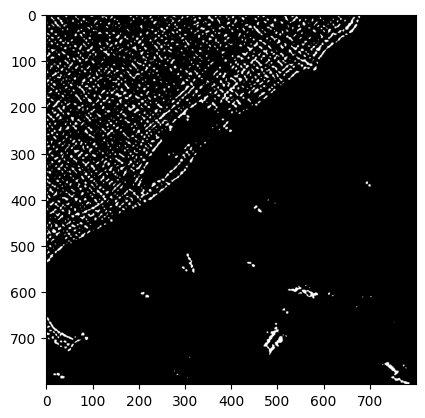

In [7]:
img1_filtered = lee_filter3(np.array(img1)/255, 5) * 255
img1_xy = cv2.Sobel(src=img1_filtered, ddepth=cv2.CV_16S, dx=1, dy=1, ksize=5)

mean_kernel5x5 = np.ones((5,5))/25
img1_mean1 = cv2.filter2D(img1_xy, -1, mean_kernel5x5)
img1_mean2 = cv2.filter2D(img1_mean1, -1, mean_kernel5x5)
ret, th1 = cv2.threshold(img1_mean2,30,277,cv2.THRESH_BINARY)
plt.imshow(th1)